In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import Heston
import rHeston
import time
import variance_curve as vc
import ImpliedDrift


from scipy.optimize import least_squares as ls
from scipy.optimize import NonlinearConstraint, Bounds

In [2]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

r = list()
q = list()

for j in range(len(maturities)):
    r.append(float(ImpliedDrift.r(maturities[j])))
    q.append(float(ImpliedDrift.q(maturities[j])))

K = moneyness*S0/100
nr = len(maturities)

In [3]:
# SVI FIT

start_time_all = time.time()

svi_param = np.zeros([nr,5])

log_moneyness = np.log(moneyness/100)

inp = np.array([3, 1, 0.5, 1, 0.5])
bnds = ([-np.inf, 0, -0.999, -np.inf, 0.00001], [np.inf, np.inf, 0.999, np.inf, np.inf])

for i in range(nr):
    
    def g(x,k):
        a,b,rho,m,sigma = x
        return a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2))
    
    def f(x):
        a,b,rho,m,sigma = x
        return g(x, log_moneyness) - IV[i,:]**2
    
    result = ls(f, inp, bounds = bnds, max_nfev = 100, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    
    svi_param[i,:] = result.x

total_time = (time.time() - start_time_all)

print(f'Total execution time: {total_time: .2f} s')

# SVI SKEW 

market_skew = np.zeros(nr)
k = 0

def f(x):
    a,b,rho,m,sigma = x
    return np.sqrt(a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2)))

for i in range(nr):
    
    def g(x):
        a,b,rho,m,sigma = x
        return b * ((k-m)/np.sqrt((k-m)**2+sigma**2)+rho) / (2*f(x))
    
    market_skew[i] = np.abs(g(svi_param[i,:]))

Total execution time:  1.34 s


In [4]:
# HESTON SKEW

h = 1e-3
K_skew = np.array([S0*(1+h), S0*(1-h)])
Heston_prms = (0.0568, 2.6707, 1.3272, -0.6774, 0.0443)
eta, kappa, theta, rho, sigma_0 = Heston_prms
Hest_skew = np.zeros(nr)
ivs = np.zeros((nr,2))
options_type = np.ones(2)

for i in range(nr):
    k_skew = K_skew*np.exp((r[i]-q[i])*maturities[i])
    ivs[i] = Heston.analytic_hest(S0, k_skew, maturities[i], r[i], q[i],  
                                     kappa, theta, rho, eta, sigma_0, options_type)
    ivs[i] = bs.BSImpliedVol(S0, k_skew, maturities[i], r[i], q[i], ivs[i,:],
                             Option_type = 1, toll = 1e-10)
    Hest_skew[i] = np.abs((ivs[i,0]-ivs[i,1])/(2*h))

<IPython.core.display.Javascript object>


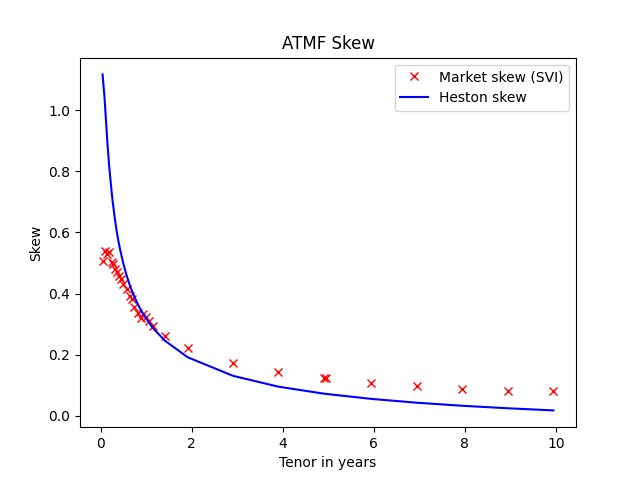

In [5]:
%matplotlib notebook

plt.plot(maturities, market_skew, 'rx')
plt.plot(maturities, Hest_skew, 'b')
plt.title('ATMF Skew')
plt.legend(['Market skew (SVI)', 'Heston skew'])
plt.xlabel('Tenor in years')
plt.ylabel('Skew')
plt.show()

In [6]:
# rHESTON SKEW

h = 1e-3
K_skew = np.array([S0*(1+h), S0*(1-h)])
rHeston_prms = (0.27021285,  0.001017  , -0.72936753)
theta, H, rho = rHeston_prms
rHest_skew = np.zeros(nr)
ivs = np.zeros((nr,2))
options_type = np.ones(2)

for i in range(nr):
    k_skew = K_skew*np.exp((r[i]-q[i])*maturities[i])
    ivs[i] = rHeston.analytic_rhest(S0, k_skew, maturities[i], H,
                                    rho, theta, options_type)
    ivs[i] = bs.BSImpliedVol(S0, k_skew, maturities[i], r[i], q[i], ivs[i,:],
                             Option_type = 1, toll = 1e-10)
    rHest_skew[i] = np.abs((ivs[i,0]-ivs[i,1])/(2*h))

<IPython.core.display.Javascript object>


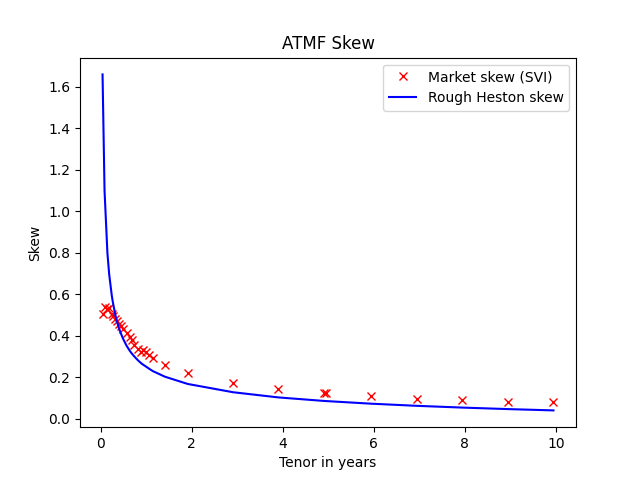

In [9]:
%matplotlib notebook
plt.title('ATMF Skew')

plt.plot(maturities, market_skew, 'rx')
plt.plot(maturities, rHest_skew, 'b')
plt.xlabel('Tenor in years')
plt.legend(['Market skew (SVI)', 'Rough Heston skew'])
plt.ylabel('Skew')
plt.show()